#### Preparing polygons within 30min and 60min walking reach within pedestrian and bike network and calculating total jobs within the polygons

In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
#import seaborn as sns
import osmnx as ox
import pyotp
import requests

In [3]:
# import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from IPython.display import IFrame
import folium
import itertools # will be used to perform feature joining


#### Read station files

In [4]:
df_al=pd.read_excel("Data/FullSUPIdentifiedData.xlsx")
df_all=df_al[['stationid', 'Latitude', 'Longitude']]
df_all=df_all.drop_duplicates(subset=['stationid'], keep='first')
df_all.reset_index(drop=True, inplace=True)

### reference: gboeing drawing isochrone maps
https://github.com/gboeing/osmnx-examples/blob/v0.13.0/notebooks/13-isolines-isochrones.ipynb

#### The travel speed is changed manually for walking and cycling and the analysis is done saperately for both.

In [75]:
trip_times = [15,30,60] #in minutes
travel_speed = 5 # speed in km/hour

In [76]:
all_station_location=(df_all.Latitude,df_all.Longitude)

In [77]:
#Download and prep the street network
isochrone_polys_15min = []
isochrone_polys_30min = []
isochrone_polys_60min = []
for stationid, x, y in zip(df_all.stationid,df_all.Latitude, df_all.Longitude):
    station_location=(x,y)
    #For bicycle (ie travel_speed the dist is increased to 15000 (for walking 8000) so that the downloaded map covers greater distance)
    G = ox.graph.graph_from_point(station_location, dist=8000, dist_type='bbox', network_type='bike', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    #distance is in meters
    gdf_nodes = ox.graph_to_gdfs(G, edges=False)
    center_node = ox.distance.nearest_nodes(G,y,x, return_dist=False)
    G = ox.project_graph(G, to_crs={'init': 'epsg:2277'})

    # add an edge attribute for time in minutes required to traverse each edge
    meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        data['time'] = data['length'] / meters_per_minute

    # make the isochrone polygons
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        if trip_time == 15:
            dic_15min={'stationid': stationid,
                  'geometry':bounding_poly}
            isochrone_polys_15min.append(dic_15min)
        elif trip_time == 30:
            dic_30min={'stationid': stationid,
                      'geometry':bounding_poly}
            isochrone_polys_30min.append(dic_30min)
        elif trip_time == 60:
            dic_60min={'stationid': stationid,
                      'geometry':bounding_poly}
            isochrone_polys_60min.append(dic_60min)
 

c:\Users\P-Koirala\AppData\Local\miniconda3\envs\OSM_miniconda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\P-Koirala\AppData\Local\miniconda3\envs\OSM_miniconda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\P-Koirala\AppData\Local\miniconda3\envs\OSM_miniconda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>

In [78]:
#Projecting the newly geenrated polygons
poly_15min = gpd.GeoDataFrame(isochrone_polys_15min, geometry='geometry')
poly_30min = gpd.GeoDataFrame(isochrone_polys_30min, geometry='geometry')
poly_60min = gpd.GeoDataFrame(isochrone_polys_60min, geometry='geometry')
poly_15min=poly_15min.set_crs('EPSG:2277')
poly_30min=poly_30min.set_crs('EPSG:2277')
poly_60min=poly_60min.set_crs('EPSG:2277')

In [80]:
#Dropping any geometry that doesnot have a polygon 
#This will delete places where there was no bike/ped network 
poly_15min_onlypoly = poly_15min[poly_15min['geometry'].geom_type == 'Polygon']
poly_30min_onlypoly = poly_30min[poly_30min['geometry'].geom_type == 'Polygon']
poly_60min_onlypoly = poly_60min[poly_60min['geometry'].geom_type == 'Polygon']

In [81]:
#The saved shp is projected map (crs=2277)
poly_15min_onlypoly.to_file('Data/Temp/job_access_poly/job_access_polygons_15min_ped.shp')
poly_30min_onlypoly.to_file('Data/Temp/job_access_poly/job_access_polygons_30min_ped.shp')
poly_60min_onlypoly.to_file('Data/Temp/job_access_poly/job_access_polygons_60min_ped.shp')

#### Read LODES data, make geodataframe and calculate job accessibility

In [154]:
poly_15min_onlypoly=gpd.read_file('Data/Temp/job_access_poly/job_access_polygons_15min_ped.shp')
poly_30min_onlypoly=gpd.read_file('Data/Temp/job_access_poly/job_access_polygons_30min_ped.shp')
poly_60min_onlypoly=gpd.read_file('Data/Temp/job_access_poly/job_access_polygons_60min_ped.shp')

In [155]:
jobs=pd.read_csv("Data/job accessibility/lodes_wac_data/unziped/tx_wac_S000_JT00_2019.csv", usecols=['w_geocode','C000'])

In [157]:
tx_blocks= gpd.read_file("Data/job accessibility/tl_2010_48_tabblock")
tx_blocks=tx_blocks[['GEOID10','geometry']]
tx_blocks=tx_blocks.to_crs('EPSG:2277')

In [158]:
tx_blocks.GEOID10=tx_blocks.GEOID10.astype('int64')
tx_blocks=tx_blocks.merge(jobs, right_on='w_geocode', left_on='GEOID10')

In [159]:
tx_blocks=tx_blocks.to_crs('EPSG:2277')
tx_blocks['area_block']=tx_blocks.geometry.area
inter15 = gpd.overlay(tx_blocks,poly_15min_onlypoly, how='intersection')
inter15["area"] = inter15['geometry'].area
inter30 = gpd.overlay(tx_blocks,poly_30min_onlypoly, how='intersection')
inter30["area"] = inter30['geometry'].area
inter60 = gpd.overlay(tx_blocks,poly_60min_onlypoly, how='intersection')
inter60["area"] = inter60['geometry'].area

In [160]:
def job_access(inter):
    ws= lambda x: round(np.sum(x*(inter.loc[x.index, "area"])/(inter.loc[x.index, "area_block"])),0)
    f= {
        'C000':ws
    }
    newdf=inter.groupby("stationid").agg(f)
    return newdf

In [161]:
job_access_15min=job_access(inter15)
job_access_15min.rename(columns={'C000':'job_access_15min'}, inplace=True)
job_access_30min=job_access(inter30)
job_access_30min.rename(columns={'C000':'job_access_30min'}, inplace=True)
job_access_60min=job_access(inter60)
job_access_60min.rename(columns={'C000':'job_access_60min'}, inplace=True)

In [162]:
job_access_15min.reset_index(drop=False, inplace=True)
job_access_60min.reset_index(drop=False, inplace=True)
job_access_30min.reset_index(drop=False, inplace=True)

In [163]:
job_access=job_access_15min.merge(job_access_30min, on='stationid', how='outer')
job_access=job_access.merge(job_access_60min, on='stationid', how='outer')
job_access=job_access[['stationid','job_access_15min', 'job_access_30min', 'job_access_60min']]
job_access.to_csv("Data/Temp/FULL_job_access_ped.csv", index=False)

#### Visualization

In [ ]:
job_access=pd.read_csv("Data/Temp/FULL_job_access_ped.csv")

In [65]:
job_access.fillna(0).mean(axis=0)

C:\Users\P-Koirala\AppData\Local\Temp\ipykernel_6404\1118460010.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  job_access.fillna(0).mean(axis=0)


job_access_15min     5401.625920
job_access_30min    68627.318115
job_access_60min    68627.318115
dtype: float64

In [ ]:
# poly_30min_onlypoly=gpd.read_file('Data/Temp/job_access_poly/job_access_polygons_30min.shp')
# poly_60min_onlypoly=gpd.read_file('Data/Temp/job_access_poly/job_access_polygons_60min.shp')
# 

In [ ]:
#FOR BIKE LOC[12] WAS USED. FOR WALK loc[7]

c:\Users\P-Koirala\AppData\Local\miniconda3\envs\OSM_miniconda\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


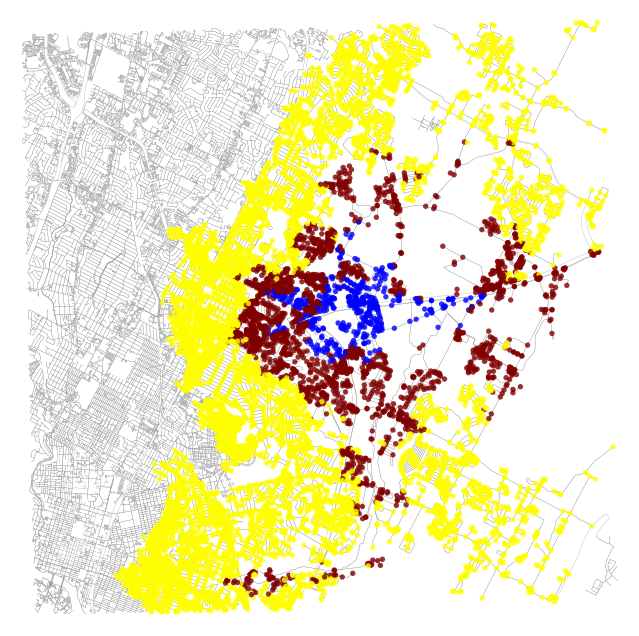

In [178]:
from matplotlib.patches import Patch
x=df_all.Latitude[7]
y=df_all.Longitude[7]
station_location=(x,y)
G = ox.graph.graph_from_point(station_location, dist=8000, dist_type='bbox', network_type='bike', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
#distance is in meters
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
center_node = ox.distance.nearest_nodes(G,y,x, return_dist=False)
G = ox.project_graph(G, to_crs={'init': 'epsg:2277'})
#
#Plot
# color the nodes according to isochrone then plot the street network
iso_colors=['yellow','maroon', 'blue']
trip_times = [15,30, 60] #in minutes
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='white', edge_linewidth=0.2, edge_color='#999999')



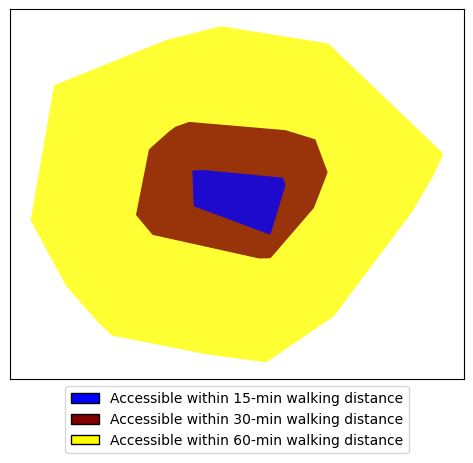

In [179]:
import geopandas as gpd
from shapely.geometry import Point
# Plot the polygons containing the point
ax = poly_60min_onlypoly.loc[[7]].plot(color='yellow', alpha=0.8)
poly_30min_onlypoly.loc[[7]].plot(ax=ax, color='maroon', alpha=0.8)
poly_15min_onlypoly.loc[[7]].plot(ax=ax, color='blue', alpha=0.8)

# Add the legend
legend_elements = [
    # Patch(facecolor='grey', edgecolor='black', label='Road Network'),
    Patch(facecolor="blue", edgecolor='black', label='Accessible within 15-min walking distance'),
    Patch(facecolor='#800000', edgecolor='black', label='Accessible within 30-min walking distance'),
    Patch(facecolor='yellow', edgecolor='black', label='Accessible within 60-min walking distance')
]
plt.legend(handles=legend_elements, title='', loc='upper center', bbox_to_anchor=(0.5, -0.0))
ax.set_xticks([])
ax.set_yticks([])
# Display the plot
plt.show()
